In [1]:
import itk
import scipy
import skimage
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
# %pylab inline

In [2]:
img_size = (int(1280/2), int(960/2))

In [3]:
template = Image.open('/Users/farid/Documents/Workspace/python/bactrace/data/samples/4_Pos_low Inflammation.tiff')
# template = skimage.color.rgb2grey(imageio.imread('/Users/farid/Documents/Workspace/python/bactrace/data/samples/4_Pos_low Inflammation.tiff'))
template = template.resize(img_size, PIL.Image.ANTIALIAS)
template = np.array(template)

# sample_name = '6_Pos_Inflammation.tiff'
sample_name = '3_Pos_Inflammation.tiff'
# sample_name = '5_Pos_low Inflammation.tiff'
# sample_name = '7_neg.tiff'
# sample_name = '8_Pos_Inflammation_suboptimal run.tiff'
sample = Image.open('/Users/farid/Documents/Workspace/python/bactrace/data/samples/' + sample_name)
sample = sample.resize(img_size, PIL.Image.ANTIALIAS)
sample = np.array(sample)
# sample = skimage.color.rgb2grey(imageio.imread('/Users/farid/Documents/Workspace/python/bactrace/data/samples/' + sample_name))
# sample = template.resize(0.5, PIL.Image.ANTIALIAS)

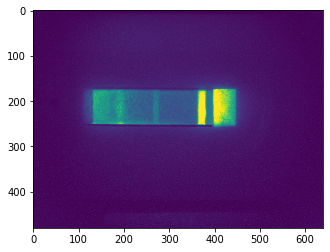

In [4]:
plt.imshow(template)

0 158


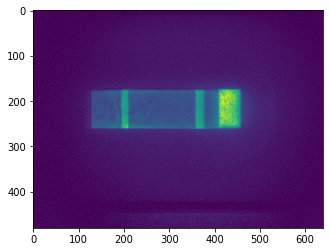

In [5]:
print(np.min(sample), np.max(sample))
plt.imshow(sample)

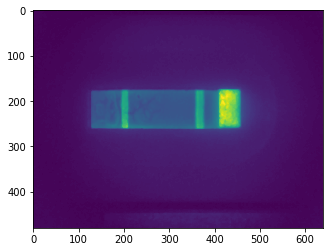

In [6]:
from scipy import ndimage
sample_med = ndimage.median_filter(sample, 5)
plt.imshow(sample_med)

In [7]:
from scipy import ndimage
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

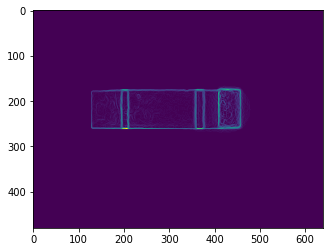

In [8]:
# sample_blur = ndimage.gaussian_filter(sample_med, sigma=1)

th = np.quantile(sample_med, 0.9)
sample_th = np.where(sample_med > th, sample_med - th, 0)

(sample_sobel, theta) = sobel_filters(sample_th.astype(np.float32))
plt.imshow(sample_sobel)

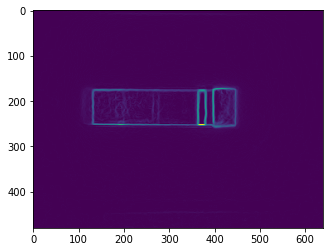

In [9]:
template_med = ndimage.median_filter(template, size=5)
template_blur = ndimage.gaussian_filter(template_med, sigma=1)

(template_sobel, theta) = sobel_filters(template_blur.astype(np.float32))
plt.imshow(template_sobel)

In [10]:
import cv2

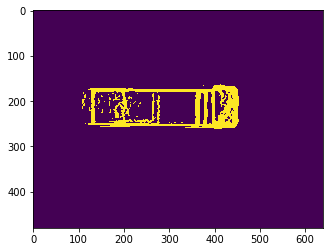

In [11]:
edge_threshold = 10
ret,thresh = cv2.threshold(template_sobel.astype(np.uint8),edge_threshold,255,0)
plt.imshow(thresh)

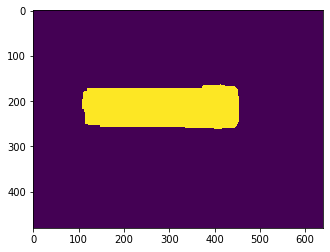

In [12]:
morph_box_size = [50, 100]
template_closed = ndimage.morphology.binary_closing(thresh, np.ones(morph_box_size), iterations=2)
plt.imshow(template_closed)

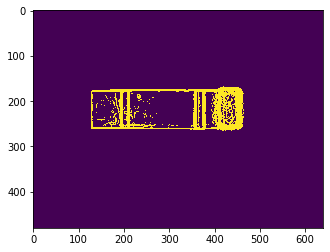

In [13]:
ret,thresh = cv2.threshold(sample_sobel.astype(np.uint8),edge_threshold,255,0)
plt.imshow(thresh)

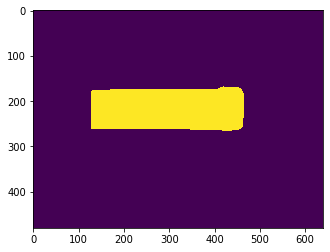

In [14]:
sample_closed = ndimage.morphology.binary_closing(thresh, np.ones(morph_box_size), iterations=2)
plt.imshow(sample_closed)

In [15]:
import SimpleITK as sitk

def command_iteration(method) :
    print("{0:3} = {1:7.5f} : {2}".format(method.GetOptimizerIteration(),
                                           method.GetMetricValue(),
                                           method.GetOptimizerPosition()))

In [16]:
fixed = sitk.GetImageFromArray(template_closed.astype(np.float) * 255)
# fixed = sitk.Normalize(fixed)
fixed = sitk.DiscreteGaussian(fixed, 2.0)
tmp1 = sitk.GetArrayFromImage(fixed).astype(np.uint8)
imageio.imwrite('fixed.jpg', tmp1)

In [17]:
moving = sitk.GetImageFromArray(sample_closed.astype(np.float) * 255)
# moving = sitk.Normalize(moving)
moving = sitk.DiscreteGaussian(moving, 2.0)
tmp2 = sitk.GetArrayFromImage(moving).astype(np.uint8)
imageio.imwrite('moving.jpg', tmp2)

In [18]:
R = sitk.ImageRegistrationMethod()

R.SetMetricAsMeanSquares()

sample_per_axis=100

tx = sitk.Euler2DTransform()
# Set the number of samples (radius) in each dimension, with a
# default step size of 1.0
R.SetOptimizerAsExhaustive([sample_per_axis//2,0,0])
# Utilize the scale to set the step size for each dimension
R.SetOptimizerScales([2.0*np.pi/sample_per_axis, 1.0,1.0])

# Initialize the transform with a translation and the center of
# rotation from the moments of intensity.
tx = sitk.CenteredTransformInitializer(fixed, moving, tx)

R.SetInitialTransform(tx)

R.SetInterpolator(sitk.sitkLinear)

R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )

outTx = R.Execute(fixed, moving)

  0 = 454.48327 : (-3.1415926535897936, 12.726328398972043, 4.201148219894378)
  1 = 852.41513 : (-3.0787608005179976, 12.726328398972043, 4.201148219894378)
  2 = 1667.74103 : (-3.0159289474462017, 12.726328398972043, 4.201148219894378)
  3 = 2494.32334 : (-2.9530970943744057, 12.726328398972043, 4.201148219894378)
  4 = 3332.73174 : (-2.8902652413026098, 12.726328398972043, 4.201148219894378)
  5 = 4196.35406 : (-2.8274333882308142, 12.726328398972043, 4.201148219894378)
  6 = 5089.31415 : (-2.7646015351590183, 12.726328398972043, 4.201148219894378)
  7 = 6011.06127 : (-2.7017696820872223, 12.726328398972043, 4.201148219894378)
  8 = 6951.63371 : (-2.6389378290154264, 12.726328398972043, 4.201148219894378)
  9 = 7831.80061 : (-2.5761059759436304, 12.726328398972043, 4.201148219894378)
 10 = 8582.41457 : (-2.5132741228718345, 12.726328398972043, 4.201148219894378)
 11 = 9235.99211 : (-2.450442269800039, 12.726328398972043, 4.201148219894378)
 12 = 9778.86440 : (-2.387610416728243, 12.

In [19]:
fixed = sitk.GetImageFromArray(template_med)
fixed = sitk.Normalize(fixed)
fixed = sitk.DiscreteGaussian(fixed, 2.0)

In [20]:
moving = sitk.GetImageFromArray(sample_med)
moving = sitk.Normalize(moving)
moving = sitk.DiscreteGaussian(moving, 2.0)

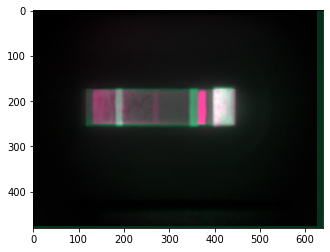

In [21]:

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed);
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)

simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
sample_registered = sitk.GetArrayFromImage(simg2)
cimg = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)
# sitk.Show( cimg, "ImageRegistration2 Composition" )
plt.imshow(sitk.GetArrayFromImage(cimg))

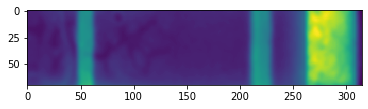

In [22]:
# cropping mask based on the template image
x1 = 270/2; x2 = 900/2; y1 = 360/2; y2 = 500/2

sample_cropped = sample_registered[int(y1):int(y2), int(x1):int(x2)]
plt.imshow(sample_cropped)

In [23]:
bin_width = 2
start_margin = 30
sample_size = sample_cropped.shape
sampling_loc = np.arange(bin_width/2 + start_margin, sample_size[1]-bin_width/2, bin_width).astype(int)

In [24]:
sample_median = np.zeros(len(sampling_loc))
for i, loc in enumerate(sampling_loc):
    sample_median[i] = np.median(sample_cropped[:,loc - int(bin_width/2) : loc + int(bin_width/2)-1])

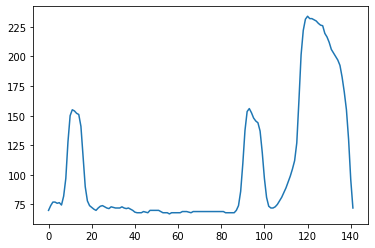

In [25]:
plt.plot(sample_median)

In [26]:
np.quantile(sample_median, np.arange(0.05, 0.95, 0.1))

array([ 68.   ,  68.575,  69.   ,  70.   ,  72.   ,  74.775,  92.6  ,
       137.375, 161.95 ])

In [27]:
from scipy.signal import find_peaks
peaks_loc, properties = find_peaks(sample_median, height=np.quantile(sample_median, 0.5), width=5, distance=15)
print(properties)

{'peak_heights': array([155., 156., 234.]), 'prominences': array([ 85.,  84., 162.]), 'left_bases': array([ 0, 56, 56]), 'right_bases': array([ 56, 103, 141]), 'widths': array([ 7.6       ,  9.06655844, 22.35777778]), 'width_heights': array([112.5, 114. , 153. ]), 'left_ips': array([  8.5       ,  90.16071429, 115.72222222]), 'right_ips': array([ 16.1       ,  99.22727273, 138.08      ])}


In [32]:
def find_noise_level(signal, peaks_properties):
    for start, end in zip(peaks_properties['left_ips'], peaks_properties['right_ips']):
        signal[int(start):int(end)] = -1    
    peak_extracted_singal = signal[np.where(signal != -1)]
    noise_level = np.median(peak_extracted_singal)
    thresholds = np.quantile(peak_extracted_singal, [0.1, 0.9])
    noise_std = np.std(peak_extracted_singal[
        np.where((peak_extracted_singal > thresholds[0]) & 
                 (peak_extracted_singal < thresholds[1]))])
    return noise_level, noise_std

In [33]:
noise_level, noise_std = find_noise_level(sample_median, properties)
print(noise_level)

70.5


In [41]:
test_2_val = None
test_1_val = None

if len(peaks_loc) > 2:
    test_1_loc = peaks_loc[0]
    test_1_val = properties['peak_heights'][0] - noise_level
if len(peaks_loc) > 3:
    test_2_loc = peaks_loc[1]
    test_2_val = properties['peak_heights'][1] - noise_level
if len(peaks_loc) > 1:
    control_loc = peaks_loc[-1]
    control_val = properties['peak_heights'][-2] - noise_level
else:
    sys.exit('Failed to find the locations')

if test_1_val is not None:
    print(test_1_val/control_val)
    z_score = test_1_val/noise_std    
    confidence_1 = scipy.stats.norm.sf(abs(z_score))
    print('p_value:', confidence_1)
if test_2_val is not None:
    print(test_2_val/control_val)
    z_score = test_2_val/noise_std    
    confidence_2 = scipy.stats.norm.sf(abs(z_score))
    print(confidence_2)

0.9883040935672515
p_value: 8.465677225092261e-85


In [30]:
print(peaks_loc)

[ 10  27  91 118]


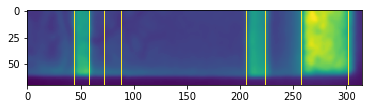

In [31]:
sample_cropped_boxes = np.copy(sample_cropped)
for loc, start, end in zip(peaks_loc, properties['left_ips'], properties['right_ips']):
    sample_cropped_boxes[:,int(start) * bin_width + start_margin] = 255
    sample_cropped_boxes[:,int(end) * bin_width + start_margin] = 255
plt.imshow(sample_cropped_boxes)

In [ ]:
from tkinter import Tk, Entry, mainloop, StringVar

root = Tk()

height = 5
width = 5
for i in range(height):  # Rows
    for j in range(width):  # Columns
        text_var = StringVar()
        # here we are setting cell text value
        text_var.set('%s%s' % (i, j)) 
        b = Entry(root, textvariable=text_var)
        b.grid(row=i, column=j)
mainloop()

In [ ]:
from tkinter import Tk, Entry, mainloop, PhotoImage, Canvas, NW   
from PIL import Image, ImageTk

In [ ]:
root = Tk()      
canvas = Canvas(root, width = 300, height = 300)      
canvas.pack()      
img = ImageTk.PhotoImage(image=Image.fromarray(np.array(sample_cropped)))     
canvas.create_image(20,20, anchor=NW, image=img)      
mainloop()